#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


# Implementacja

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from collections.abc import Iterable
from copy import copy

np.set_printoptions(legacy='1.25')

In [43]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

def rand_uni(probability: float) -> bool:
  return np.random.uniform(0, 1) <= probability


def bit2int(bit_array):
  val = 0
  for digit in bit_array:
    val *= 2
    val += digit
  return val

In [44]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.genes: np.ndarray = array if array is not None else np.random.randint(2, size=length)
    self.length = length

  def decode(self, lower_bound: int, upper_bound: int, aoi: Iterable[float]) -> float:
    new_low, new_high = aoi
    bits_per_arg = upper_bound - lower_bound
    max_int = 1 << bits_per_arg
    value = bit2int(self.genes[lower_bound:upper_bound])
    return min_max_norm(value, 0, max_int, new_low, new_high)

  def mutation(self, probability: float):
    if rand_uni(probability):
      idx = np.random.randint(0, self.genes.shape[0] - 1)
      self.genes[idx] = 1 - self.genes[idx]

  def crossover(self, other):
    cut_point = np.random.randint(0, self.length + 1)
    new_genes = np.append(self.genes[0:cut_point], other.genes[cut_point:])
    return Chromosome(self.length, new_genes)


In [45]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

    # initialize population
    self.pop_size = population_size
    self.population = np.array([Chromosome(self.chromosome_lengths) for _ in range(population_size)])
    self._evaluate_population()

  def get_args(self, chromosome: Chromosome) -> Iterable[float]:
    args = []
    for narg in range(self.obj_func_num_args):
      lo = self.bits_per_arg * narg
      hi = lo + self.bits_per_arg
      val = chromosome.decode(lo, hi, self.aoi)
      args.append(val)
    return args

  def eval_objective_func(self, chromosome: Chromosome) -> float:
    args = self.get_args(chromosome)
    return self.objective_function(*args)

  def tournament_selection(self):
    old_population = copy(self.population)
    for index in range(self.pop_size):
      chromos = np.random.choice(old_population, self.tournament_size)
      winner = self._get_best_chromosome(chromos)
      self.population[index] = winner

  def reproduce(self, parents: Iterable[Chromosome]):
    for index, chromosome in enumerate(parents):
      if rand_uni(self.crossover_probability):
        second = np.random.choice(parents, 1)[0]
        chromosome = chromosome.crossover(second)
      
      chromosome.mutation(self.mutation_probability)
      
      parents[index] = chromosome
    return parents
        

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()


  def _get_best_chromosome(self, chromosomes: Iterable[Chromosome]):
    scores = [self.eval_objective_func(c) for c in chromosomes]
    best_ind = np.argmin(scores)
    return chromosomes[best_ind]


  def _evaluate_population(self):
    self.scores = [self.eval_objective_func(c) for c in self.population]
    self.best_ind = np.argmin(self.scores)
    self.best_score = self.scores[self.best_ind]
    self.best_chromosome = self.population[self.best_ind]
    self.best_args = self.get_args(self.best_chromosome)


  def run(self, debug=False):
    trace = []
    for i in range(self.num_steps):
      self.tournament_selection()
      self.population = self.reproduce(self.population)
      self._evaluate_population()

      if (debug):
        print(f'{i=:02}, {self.best_args}, {self.best_score}')
      trace.append(self.best_args)
    
    self.plot_func(trace)
    print(f'Result: (x1,x2)={self.best_args}, q={self.best_score}')



In [46]:
def f(x1: float, x2: float) -> float:
    return (
        1.5
        - np.exp(-(x1 ** (2)) - x2 ** (2))
        - 0.5 * np.exp(-((x1 - 1) ** (2)) - (x2 + 2) ** (2))
    )

# Uruchomienie

POPULATION
chromo_len=16, pop_size=20, mut_prot=0.05, cross_prot=0.8


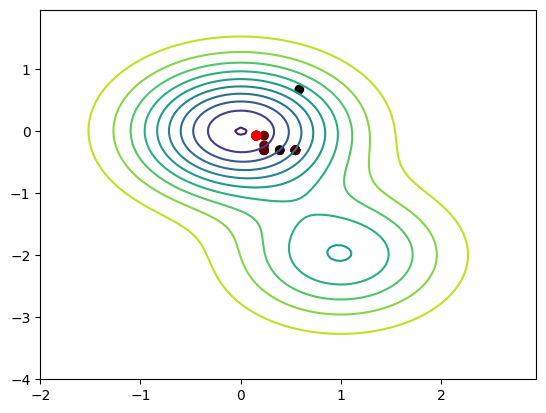

Result: (x1,x2)=[0.15625, -0.078125], q=0.5239517252379675
-----------
chromo_len=16, pop_size=100, mut_prot=0.05, cross_prot=0.8


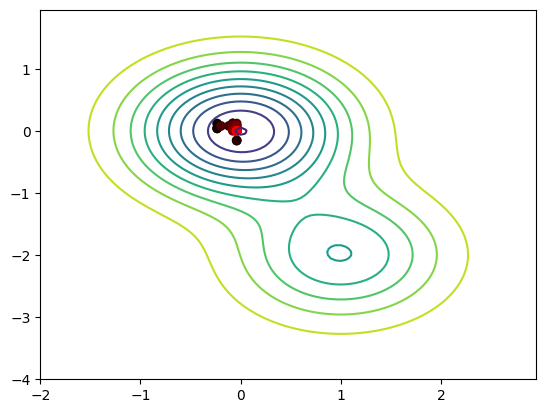

Result: (x1,x2)=[-0.0390625, 0.0], q=0.4984136748966829
-----------
chromo_len=16, pop_size=300, mut_prot=0.05, cross_prot=0.8


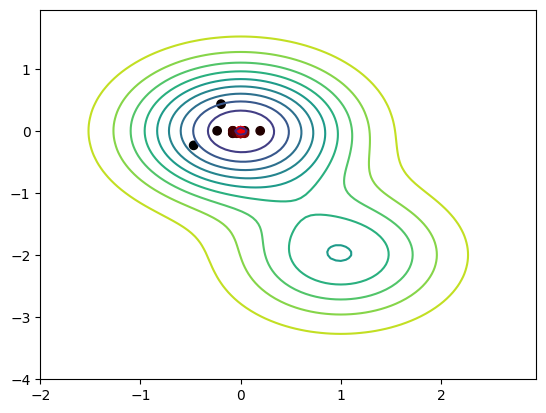

Result: (x1,x2)=[0.0, 0.0], q=0.49663102650045726
-----------
chromo_len=16, pop_size=1000, mut_prot=0.05, cross_prot=0.8


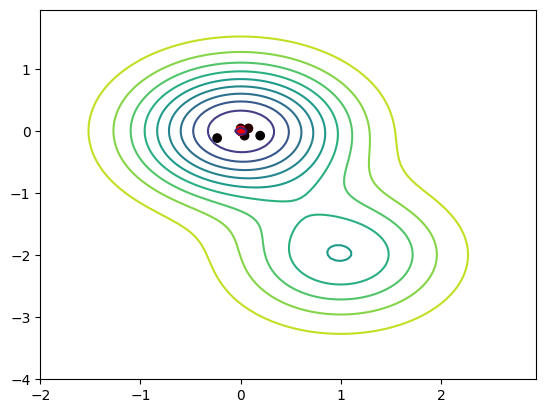

Result: (x1,x2)=[0.0, 0.0], q=0.49663102650045726
-----------
CRHOMOSOME LENGTH

chromo_len=8, pop_size=500, mut_prot=0.05, cross_prot=0.8


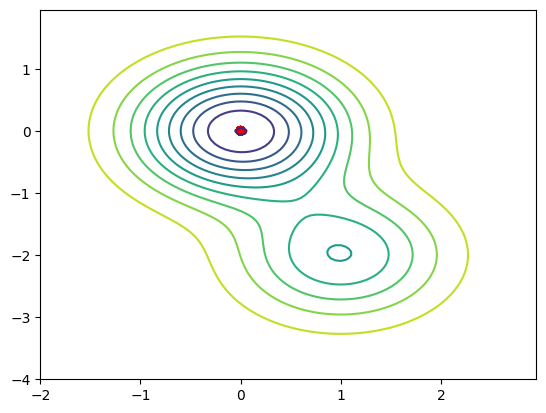

Result: (x1,x2)=[0.0, 0.0], q=0.49663102650045726
-----------
chromo_len=16, pop_size=500, mut_prot=0.05, cross_prot=0.8


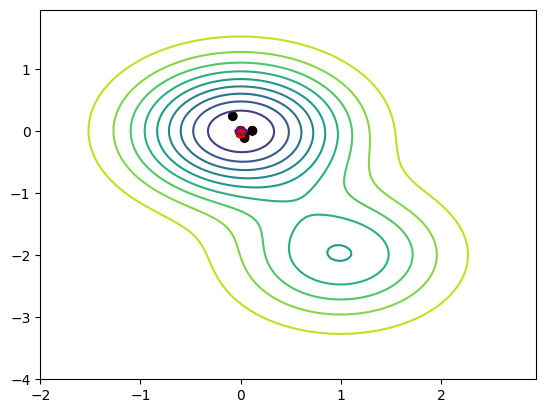

Result: (x1,x2)=[0.0, -0.0390625], q=0.497591991722595
-----------
chromo_len=24, pop_size=500, mut_prot=0.05, cross_prot=0.8


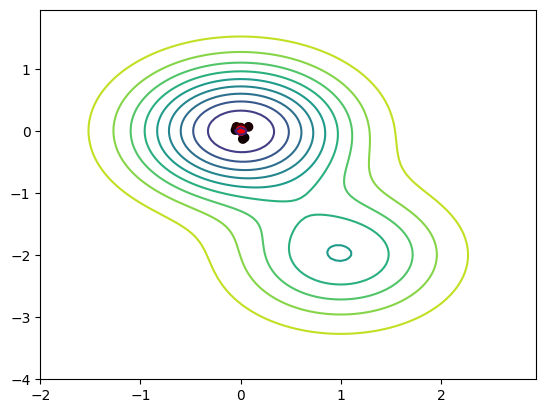

Result: (x1,x2)=[0.00244140625, 0.0], q=0.49662051683339176
-----------
MUTATION

chromo_len=16, pop_size=500, mut_prot=0.05, cross_prot=0.8


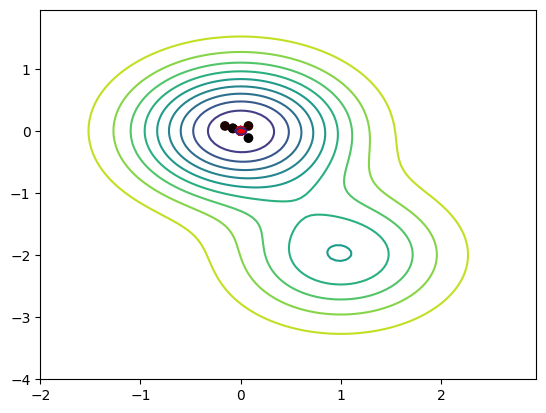

Result: (x1,x2)=[0.0, 0.0], q=0.49663102650045726
-----------
chromo_len=16, pop_size=500, mut_prot=0.1, cross_prot=0.8


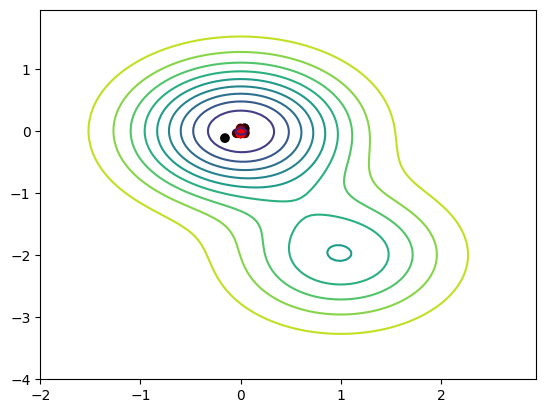

Result: (x1,x2)=[0.0, -0.0390625], q=0.497591991722595
-----------
chromo_len=16, pop_size=500, mut_prot=0.4, cross_prot=0.8


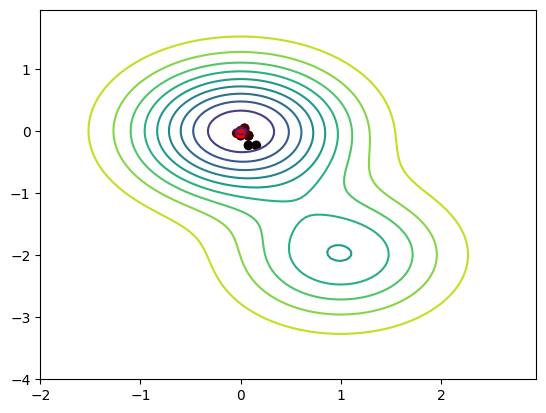

Result: (x1,x2)=[0.0, -0.0390625], q=0.497591991722595
-----------
CROSSOVER

chromo_len=16, pop_size=500, mut_prot=0.2, cross_prot=0.8


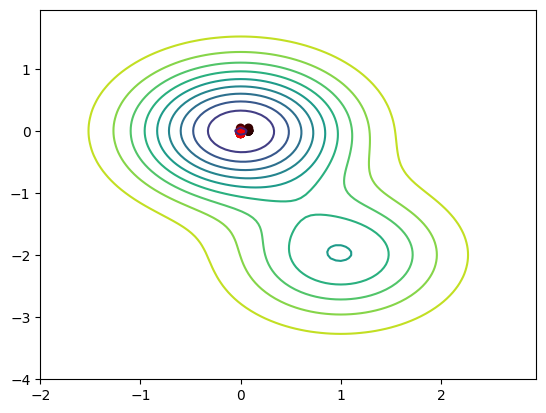

Result: (x1,x2)=[0.0, -0.0390625], q=0.497591991722595
-----------
chromo_len=16, pop_size=500, mut_prot=0.5, cross_prot=0.8


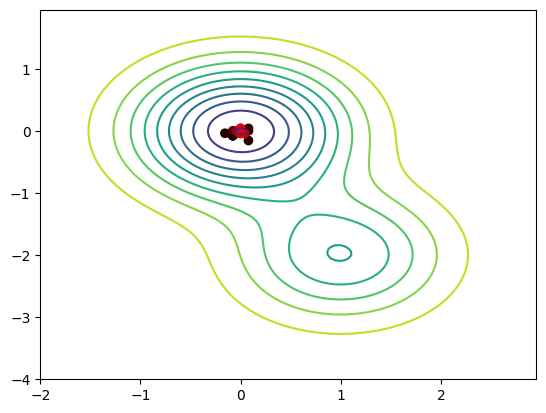

Result: (x1,x2)=[0.0, -0.0390625], q=0.497591991722595
-----------
chromo_len=16, pop_size=500, mut_prot=0.8, cross_prot=0.8


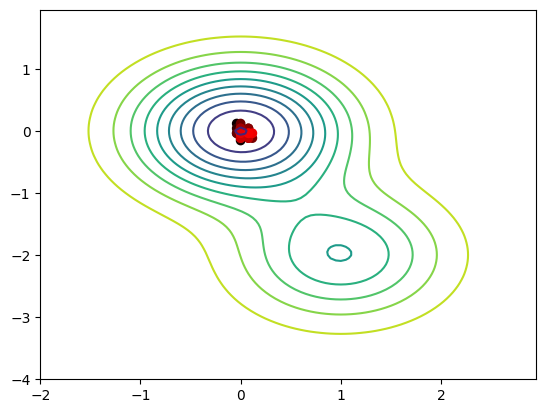

Result: (x1,x2)=[0.078125, -0.0390625], q=0.503030522241624
-----------


In [47]:
# aoi = [-10, 10]

# for pop_size in [20, 100, 1000]:
#     for chromo_len in [8, 16, 24]:
#         print(f'CH LEN: {chromo_len}, POP SIZE: {pop_size}')
#         algo = GeneticAlgorithm(chromo_len, 2, f, aoi, population_size=pop_size)
#         algo.run(debug=False)
#         print('-----------')


# print("\n====\n")



# for mut_prot in [0.05, 0.1, 0.5]:
#     for cross_prot in [0.2, 0.5, 0.8]:
#         print(f'{chromo_len=}, {pop_size=}, {mut_prot=}, {cross_prot=}')
#         algo = GeneticAlgorithm(chromo_len, 2, f, aoi, population_size=pop_size, mutation_probability=mut_prot, crossover_probability=cross_prot)
#         algo.run(debug=False)
#         print('-----------')

aoi = [-5, 5]
pop_size = 500
chromo_len = 16
mut_prot = 0.05
cross_prot = 0.8

print("POPULATION")

for pop_size in [20, 100, 300, 1000]:
    print(f'{chromo_len=}, {pop_size=}, {mut_prot=}, {cross_prot=}')
    algo = GeneticAlgorithm(chromo_len, 2, f, aoi, population_size=pop_size, mutation_probability=mut_prot, crossover_probability=cross_prot)
    algo.run(debug=False)
    print('-----------')

print("CRHOMOSOME LENGTH\n")
pop_size = 500

for chromo_len in [8, 16, 24]:
    print(f'{chromo_len=}, {pop_size=}, {mut_prot=}, {cross_prot=}')
    algo = GeneticAlgorithm(chromo_len, 2, f, aoi, population_size=pop_size, mutation_probability=mut_prot, crossover_probability=cross_prot)
    algo.run(debug=False)
    print('-----------')

print("MUTATION\n")
chromo_len = 16
for mut_prot in [0.05, 0.1, 0.4]:
    print(f'{chromo_len=}, {pop_size=}, {mut_prot=}, {cross_prot=}')
    algo = GeneticAlgorithm(chromo_len, 2, f, aoi, population_size=pop_size, mutation_probability=mut_prot, crossover_probability=cross_prot)
    algo.run(debug=False)
    print('-----------')

print("CROSSOVER\n")
mut_prot = 0.1
for mut_prot in [0.2, 0.5, 0.8]:
    print(f'{chromo_len=}, {pop_size=}, {mut_prot=}, {cross_prot=}')
    algo = GeneticAlgorithm(chromo_len, 2, f, aoi, population_size=pop_size, mutation_probability=mut_prot, crossover_probability=cross_prot)
    algo.run(debug=False)
    print('-----------')

# Wnioski



## Porównanie z metodą gradientową
Algorytm genetyczny nie korzysta z gradientu funkcji, więc można go użyć gdyby gradient był
bardzo trudny lub niemożliwy do obliczenia. Ma też dużo słabsze tendencje do utykania w ekstremach lokalnych.

M. gradientowa do zmaksymalizowania szansy znalezienia najlepszego rozwiązania wymaga wieloktronego uruchomienia z różnymi punktami początkowymi.
A. genetyczny robi coś podobnego przez trzymanie całej populacji chromosów, z tą różnicą że osobniki na siebie oddziałowują, a te najgorsze są
systematycznie usuwane.